# Korean Jamo Image Recognition

This demo will use a dataset of Korean characters to train a model to recognize common Korean Jamo.

## Dataset

This demo uses a dataset of 1000 150x150 images, which each contain a single Korean Jamo. The Jamo are handwritten using a graphics tablet. The dataset is organized into a grid of 150x150 pixel cells that is 20 Jamo wide and 50 Jamo high. Labels are provided in a JSON serialized array. As the data was developed by hand alone, it uses a subset of Korean Jamo to make it easier to manage the amount of data that would be required for training. The current subset of Jamo being used is:

> ㄱ ㄴ ㄷ ㄹ ㅁ ㅂ ㅅ ㅇ ㅈ ㅊ ㅋ ㅌ ㅍ ㅎ ㅏ ㅐ ㅑ ㅓ ㅔ ㅕ ㅗ ㅛ ㅜ ㅠ ㅡ ㅣ


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.font_manager as fm

In [0]:
# Setup Korean-Friendly Font - Necessary as by default matplotlib cannot
# properly display Korean characters

!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
!unzip "NotoSansCJKkr-hinted"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype

path = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
fontprop = fm.FontProperties(fname=path, size= 15)

--2019-09-27 14:58:09--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 108.177.120.128, 2607:f8b0:4001:c18::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip.3’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   185MB/s    in 0.6s    

2019-09-27 14:58:10 (185 MB/s) - ‘NotoSansCJKkr-hinted.zip.3’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: NotoSansCJKkr-Medium.otf  


In [0]:
# Mount google drive to load image/label data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Session used to evaluate tensors at runtime
# Currently necessary for interaction with matplotlib, though there should be an
# alternative solution that doesn't require eager evaluation through an interactive session
sess = tf.InteractiveSession()

In [0]:
# Read in label data - labels are stored as korean characters, so we will 
# map them to a numeric index and create an array of those values
source_labels = pd.read_json('/content/drive/My Drive/hangul-jamo-ml/labels.json', orient="values", typ="series")
source_test_labels = pd.read_json('/content/drive/My Drive/hangul-jamo-ml/test-labels.json', orient="values", typ="series")

# Index values from this array will be used to map resultant evaluation values to the jamo that they refernece
label_values = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㅏ', 'ㅐ', 'ㅑ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ']
training_labels = []
test_labels = []

# convert original jamo lables to indexed values
for label in source_labels:
  training_labels.append(label_values.index(label))

for label in source_test_labels:
  test_labels.append(label_values.index(label))

In [0]:
# Helper function to process data and return tuple of 
def process_image(image, image_height, image_width, sub_image_height=150, sub_image_width=150):
  # Invert image so that high values represent important parts of the image rather than unimportant
  image = 255 - image
  
  # Reshape tensor for use with matplotlib
  image = tf.reshape(image, [-1, sub_image_height, sub_image_width, 1])
  # Convert tensor values to float (required by matplotlib - not sure why?)
  image = tf.cast(image, tf.float32)
  image = tf.reshape(image, [-1, sub_image_height * image_height, sub_image_width * image_width])
  
  # Map subimages into a batch structure so that they can be handled individually
  image_batch = []
  for y in range (0, image_height):
    for x in range(0, image_width):
      cur_slice = tf.slice(image[0], [y*sub_image_height, x*sub_image_width], [sub_image_height, sub_image_width])
      image_batch.append(cur_slice)
      
  # Format Acceptable by matplotlib, as it requires the grayscale pixel value be in an array
  graphable_data = tf.convert_to_tensor(image_batch)
  # TF does not require this array for processing, so it is removed for the process data
  process_data = tf.reshape(graphable_data, [image_height * image_width, sub_image_width, sub_image_height, 1])
  return (graphable_data, process_data)

In [0]:
# Read in training image files
image = tf.image.decode_jpeg(tf.read_file('/content/drive/My Drive/hangul-jamo-ml/dataset.jpg'), channels=1)
(training_graph_data, training_process_data) = process_image(image, 50, 20)

# Read in testing image files
test_image = tf.image.decode_jpeg(tf.read_file('/content/drive/My Drive/hangul-jamo-ml/test-data.jpg'), channels=1)
(test_graph_data, test_process_data) = process_image(test_image, 10, 5)


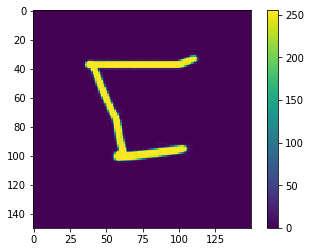

In [0]:
# Sample plot of a single subimage
plot.figure()
plot.imshow(training_graph_data[0].eval())
plot.colorbar()
plot.grid(False)
plot.show()

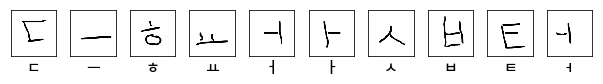

In [0]:
# Plotting first 10 items with labels
# Sample from the dataset
plot.figure(figsize=(160,160))
for i in range(10):
  plot.subplot(160,150,i+1)
  plot.xticks([])
  plot.yticks([])
  plot.xlabel(source_labels[i], fontproperties=fontprop)
  plot.imshow(training_graph_data[i].eval(), cmap=plot.cm.binary)
  
plot.show()

In [0]:

# Model setup
# NN leverages multiple layers of convolution and pooling
# Convolution layers randomly extract properties from the image to focus on 
# Well fitting convolution layers will extract useful properties that help the NN identify Jamo
# Convolution layers are followed by pooling layers, which help to reduce image noise and 
# emphasize patterns in the image

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])


model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(training_process_data, training_labels, epochs=45, steps_per_epoch=1, verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
____

In [0]:
# Test against test data
test_loss, test_acc = model.evaluate(test_process_data, test_labels, steps=1)
print('Test accuracy:', test_acc)

1/1 [==============================] - 1s 790ms/step - loss: 0.0682 - acc: 0.9800
Test accuracy: 0.98


In [0]:
# Utility function to view evaluation results with actual image
def show_prediction(id, process_data, graph_data):
  prediction_data = model.predict(tf.convert_to_tensor([process_data[id]]), steps=1)[0]
  print(prediction_data)
  max_value = prediction_data[0];
  max_index = 0

  for x in range(1, 26):
    if prediction_data[x] > max_value:
      max_value = prediction_data[x]
      max_index = x

  predictedHangul = label_values[max_index]


  plot.figure()
  plot.imshow(graph_data[id].eval())
  plot.colorbar()
  plot.grid(False)
  plot.xlabel('Prediction: ' + predictedHangul, fontproperties=fontprop)
  plot.show()

[6.9800069e-07 6.5261387e-04 2.7895103e-05 1.2191073e-03 1.4777191e-03
 4.2595032e-01 6.9325280e-05 3.7226670e-05 1.0067614e-06 1.7456384e-04
 2.6843374e-05 3.7644155e-04 3.6933940e-05 9.7401551e-07 7.9084944e-05
 5.6905580e-01 3.1666516e-04 6.0776401e-05 2.0598996e-04 3.5852812e-05
 3.9378861e-07 8.9471432e-05 1.7446175e-05 3.0521162e-06 6.2648709e-08
 8.3737963e-05]


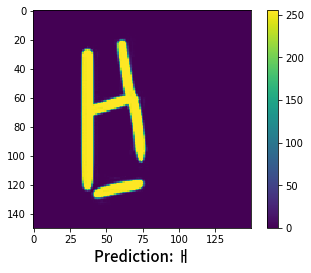

In [0]:
show_prediction(24, test_process_data, test_graph_data)

In [0]:
model